# Задание №3

Обучить СНС с помощью Transfer Learning на датасете Food-101.
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]

> Возьмем предобученную сеть MobileNetV2 и дообучим в режимах Transfer learning и Fine-tuning
> Будем использовать веса MobileNetV2 на наборе Imagenet
> Целевым набором будет Food101

## MobileNet-v2
MobileNet-v2 является сверточной нейронной сетью, глубина которой составляет 53 слоя. Можно загрузить предварительно обученную версию сети, обученной больше чем на миллионе изображений от базы данных [ImageNet](https://image-net.org/). Предварительно обученная сеть может классифицировать изображения в 1 000 категорий объектов. В результате сеть изучила богатые представления функции для широкого спектра изображений. Сеть имеет входной размер изображений 224 224. [Статья](https://habr.com/ru/post/352804/)

## ImageNet
База данных ImageNet — проект по созданию и сопровождению массивной базы данных аннотированных изображений, предназначенная для отработки и тестирования методов распознавания образов и машинного зрения. По состоянию на 2016 год в базу данных было записано около десяти миллионов URL с изображениями, которые прошли ручную аннотацию для ImageNet, в аннотациях перечислялись объекты, попавшие на изображение, и прямоугольники с их координатами.[1] База данных с аннотацией и URL изображений от третьих лиц доступна непосредственно через ImageNet, но при этом сами изображения не принадлежат проекту[2]. С 2010 года ведётся проект ILSVRC (англ. ImageNet Large Scale Visual Recognition Challenge — Кампания по широкомасштабному распознаванию образов в ImageNet), в рамках которого различные программные продукты ежегодно соревнуются в классификации и распознавании объектов и сцен в базе данных [ImageNet](https://ru.wikipedia.org/wiki/ImageNet).

## Food-101
Этот набор данных состоит из 101 категории продуктов питания и 101 000 изображений. Для каждого класса предоставляется 250 проверенных вручную тестовых изображений, а также 750 обучающих изображений. Учебные изображения намеренно не очищались и поэтому все еще содержат некоторое количество шума. В основном это проявляется в виде интенсивных цветов и иногда неправильных этикеток. Все изображения были масштабированы таким образом, чтобы максимальная длина стороны составляла 512 пикселей. [food101](https://www.tensorflow.org/datasets/catalog/food101)



In [1]:
# для локальноого прогона
#!pip install tensorflow-datasets

## Импорт данных

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета Food101

In [22]:
%%time
# tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:10%]', 'validation[:10%]'],
)

label_names = ds_info.features['label'].names

CPU times: user 66.4 ms, sys: 819 µs, total: 67.2 ms
Wall time: 72.9 ms


> Будем использовать 10% оригинальной базы для ускорения обучения

In [23]:
print(f'Train exemples: {len(train_ds)}')
print(f'Test examples: {len(test_ds)}')
print(f'Labels: {len(label_names)}')

Train exemples: 7575
Test examples: 2525
Labels: 101


## Визуализация набора Food101

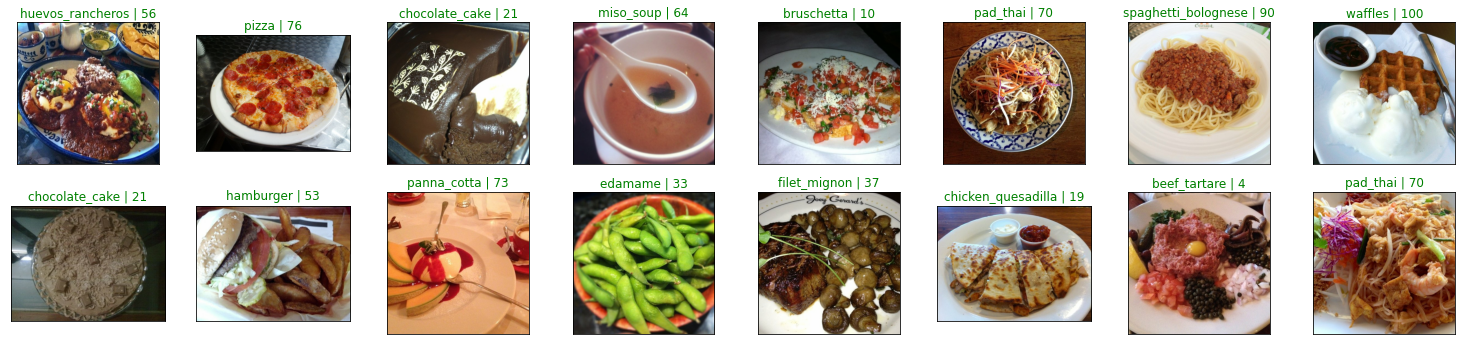

In [24]:
some_samples = [x[0] for x in iter(train_ds.take(16))]
some_labels = [x[1].numpy() for x in iter(train_ds.take(16))]

fig = plt.figure(figsize=(26, 12))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j + 1)
    ax.imshow(some_samples[j])
    ax.set_title(label_names[some_labels[j]] + ' | ' + str(some_labels[j]), c='green')
    plt.xticks([]), plt.yticks([])
plt.show()

> Необходимо привести высоту и ширину

In [25]:
for i in some_samples[:10]:
  print(i.shape)

(512, 512, 3)
(384, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(384, 512, 3)
(384, 512, 3)


In [26]:
img_w = set()
img_h = set()
for item in train_ds:
  if item[0].shape[0] != 512:
    img_w.add(item[0].shape[0])
  elif item[0].shape[1] != 512:
    img_h.add(item[0].shape[1])
print(f'Min width: {min(img_w)}\nMin height: {min(img_h)}')

Min width: 181
Min height: 223


## Создание пайплайна данных

In [27]:
INP_SIZE = 224
NUM_EPOCHS = 1
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000


def resize_images(img, label):
    img = tf.cast(img, tf.float32) / 127. - 1.  # значения от -1 до 1 для модели MobileNetV2
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.map(resize_images, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=BUFFER_SIZE)
test_ds = test_ds.map(resize_images, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(128, drop_remainder=True)

## Подготовка модели

In [33]:
if 1: # Обучение модели MobileNetV2

    # EXP_NAME = 'MobileNetV2'
    # EXP_NAME = 'MobileNetV2_augmentaion'
    EXP_NAME = 'MobileNetV2_trainable_false'
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet',  # предобученные веса
    )
    # base_model.trainable = True  # Fine-tuning весов предобученной модели
    base_model.trainable = False  # Заморозка весов предобученной модели

if 0: # Обучение модели EfficientNetV2S

    EXP_NAME = 'EfficientNetV2S'
    base_model = tf.keras.applications.EfficientNetV2S(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet',
        include_preprocessing=False,
    )
    base_model.trainable = True  # Fine-tuning весов предобученной модели
    # base_model.trainable = False  # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

In [ ]:
class BuildModel:
  INP_SIZE = 224
  def __init__(self, name, is_fine_tuning=False) -> None:
    self.is_fine_tuning = is_fine_tuning
    self.basemodel = self.build_base(self.is_fine_tuning)
    self.model = self.build_base(self.is_fine_tuning)

  def build_seq(self):
    return tf.keras.Sequential([self.basemodel,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(101, activation='softmax'),
    ])

  def build_base(self, is_fine_tuning):
    return None

class MobilNat(BuildModel):
    def build_base(self, is_fine_tuning):
      model = tf.keras.applications.MobileNetV2(
        input_shape=(self.INP_SIZE, self.INP_SIZE, 3),
        include_top=False,
        weights='imagenet' )
      model.trainable = is_fine_tuning
      return model


class EfficientNet(BuildModel):
    def build_base(self, is_fine_tuning):
        model =  tf.keras.applications.EfficientNetV2S(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet',
        include_preprocessing=False,    )
        model.trainable = is_fine_tuning
        return model

    

## Подготовка к обучению

In [34]:
LEARNING_RATE = 0.0001
OPTIMISER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMISER,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/' + EXP_NAME,
    write_graph=False, update_freq=100, profile_batch=0)

## Структура модели

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


## Обучение модели

In [36]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

236/236 [==============================] - 33s 125ms/step - loss: 4.5261 - accuracy: 0.0388 - val_loss: 4.0928 - val_accuracy: 0.0929
CPU times: user 49.8 s, sys: 1.03 s, total: 50.9 s
Wall time: 32.7 s


## Оценка качества модели


In [32]:
history_test = model.evaluate(test_ds)
history_test

19/19 [==============================] - 6s 264ms/step - loss: 4.1134 - accuracy: 0.0876


[4.11336088180542, 0.08758223801851273]

## Панель TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%` not found.


## Разпознавание картинки